### Beispiel eines Neuronalen Netzes zur Vorhersage von Kundenabwanderung
Genutzt wird in diesem Fall ein **LSTM**-Netz (Long-Short-Term-Memory)
, welches besonders gut für die Analyse von längeren Sequenzen (Texte, Kursverläufe etc.) geeignet ist.
In unserem Fall sind dies Bestellverläufe verschiedener Kunden. Ziel ist es, das Netz auf einen Teil der Kundenbestellungen zu trainieren, und mit dem Rest zu testen ob das System diese richtig als abgesprungen oder nicht abgesprungen klassifiziert.

Im folgenden finden Sie die Codefragmente mit den zugehörigen Beschreibungen. Diese müssen nacheinander von Ihnen ausgeführt werden.

Import der notwendigen Bibliotheken:
* **Keras** - Hauptframework für Machine Learning. (Basiert auf Google's Tensorflow)
* **Numpy** - Unter anderem zur Durchführung von Vektorberechnungen.
* **Pandas** - Regelt den Import und die Formatierung von Daten. 

In [6]:
import random as rn
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import unittest
from dateutil.relativedelta import relativedelta
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Masking, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from numpy.random import seed

%load_ext ipython_unittest

Funktion, welche einen *Inner-Join* auf zwei Datensätzen ausführt.

In [2]:
def drop_missing_values_vise_versa(df1, df2, column_name):
    drop_condition = df1[column_name].isin(df2[column_name]) == False
    df1 = df1.drop(df1[drop_condition].index)
    drop_condition = df2[column_name].isin(df1[column_name]) == False
    df2 = df2.drop(df2[drop_condition].index)
    return df1, df2

Funktion, welche fehlende Daten einer Zeitreihe auffüllt.

In [3]:
def fill_dates(df, end_date):
    start_date = df['date'].iloc[0]
    if start_date > end_date or len(df) == 0:
        return df
    diff = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)
    date_list = [start_date + relativedelta(months=x) for x in range(0, diff)]
    date_frame = pd.DataFrame(date_list)
    date_frame.columns = ['date']
    value = pd.merge(date_frame, df, how='left').fillna(0)
    value = value.drop(['date'], axis=1)
    return value

Funktion, welche einen Datensatz in einem gewählten Verhältnis teilt.

In [55]:
def train_test_split(df, ratio):
    train = np.array(df[:round(len(df) * ratio)])
    test = np.array(df[-round(len(df) * (1 - ratio)):])
    return train, test

In [56]:
%%unittest_testcase
def test_train_test_split(self):
    
    data = np.random.rand(620,4,3,2,1)
    
    splits = [0.0, 0.3, 0.6, 1.0]
    for split in splits:
        print(f'Split = {split}')
        splitted_data = train_test_split(data, split)
        assert len(splitted_data) == 2
        data_test, data_train = splitted_data
        
        test_shape = data_test.shape
        train_shape = data_train.shape
        
        for i, (s1, s2) in enumerate(zip(test_shape, train_shape)):
            if i == 0:
                train_shape_asserted = int(data.shape[0] * split)
                test_shape_asserted = int(data.shape[0] * (1-split))
                print(f'Assert Train Len.: {train_shape_asserted}, Erhaltene Train Len.: {s1}')
                print(f'Assert Test Len.: {test_shape_asserted}, Erhaltene Train Len.: {s2}')
                assert s1 == train_shape_asserted
                assert s2 == test_shape_asserted
            else:
                assert s1 == s2
        print()

Split = 0.0
Assert Train Len.: 0, Erhaltene Train Len.: 0
Assert Test Len.: 620, Erhaltene Train Len.: 620

Split = 0.3
Assert Train Len.: 186, Erhaltene Train Len.: 186
Assert Test Len.: 434, Erhaltene Train Len.: 620


Fail

F
FAIL: test_train_test_split (__main__.JupyterTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "Cell Tests", line 22, in test_train_test_split
AssertionError

----------------------------------------------------------------------
Ran 1 test in 0.005s

FAILED (failures=1)


<unittest.runner.TextTestResult run=1 errors=0 failures=1>

Funktion, welche *Random-Seeds* setzt.

In [10]:
def set_random_seed(s):
    seed(s)
    rn.seed(s)
    tf.random.set_seed(s)

Einlesen der Daten mithilfe von **Pandas**
* Es wird zwischen X und Y-Werten unterschieden.
* Die X-Werte sind in unserem Fall die Bestellverläufe.
* Der Y-Wert ist ein *boolean*-Wert, welcher besagt ob ein Kunde abgesprungen ist.

In [11]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d')
x_data = x_data.drop("quantity", axis=1)
x_data = x_data[x_data.date < '2018-09-01']


In [12]:
y_data = pd.read_csv("cleaned_y_data.csv", header=0, index_col=0, sep=",", dtype={0:int,1:int})
y_data = y_data.sort_values('recipient').reset_index(drop=True)

In [13]:
x_data, y_data = drop_missing_values_vise_versa(x_data, y_data, 'recipient')

Kleiner Ausschnitt der X und Y-Werte:

In [14]:
x_data.head(10)

,recipient,date,sales
808,11675,2015-06-01,1014.0
809,11675,2015-07-01,4630.0
810,11675,2015-08-01,1425.0
811,11675,2015-09-01,532.0
812,11675,2015-10-01,3656.0
813,11675,2015-11-01,1272.0
814,11675,2015-12-01,2799.0
815,11675,2016-01-01,671.0
816,11675,2016-02-01,5232.0
817,11675,2016-04-01,2119.0


In [15]:
y_data.head(10)

,recipient,churned
0,11675,0
1,12589,0
2,13593,1
3,14080,1
4,14089,0
5,14094,0
6,14095,1
7,14098,1
8,14100,0
9,14103,1


Die drei folgenden Code-Zellen dienen der Transformation der X-Werte in ein 3D-Array, um diese für das Netzwerk lesbar zu machen.

In [16]:
x_data_dict =  dict()
x_data_grouped = x_data.groupby('recipient')
for recipient in x_data_grouped.groups:
    x_data_dict[recipient] = pd.DataFrame(x_data_grouped['date','sales'].get_group(recipient))
assert len(x_data_dict) == len(y_data)

In [17]:
X = list()
for key, item in x_data_dict.items():
    X.append(fill_dates(item, datetime.strptime("2018-09-01","%Y-%m-%d")).values.tolist())

In [18]:
X = pad_sequences(X, value=-1,dtype='float32')
y = np.array(y_data['churned'].values)
y = y.reshape(y.shape[0],1)

Aufteilung der Daten in 70% Trainings- und 30% Testdaten:

In [19]:
X_test, X_train = train_test_split(X, 0.3)
y_test, y_train = train_test_split(y, 0.3)
print(X_test.shape, X_train.shape)

(106, 43, 1) (246, 43, 1)


**An dieser Stelle sind Sie gefragt..**
Das nachfolgende Codefragment enthält 4 modifizierbare Parameter, welche essenziell für die Genauigkeit des Netzwerks sind.
Diese sind so initialiert, dass das Netwerk ohne Veränderung eine schlechte Performance aufweist.
Ihre Aufgabe ist es nun diese Parameter so anzupassen, dass eine möglichst hohe Genauigkeit erzielt wird.

Die Parameter sind wie folgt beschrieben:
* **learning_rate**: Lernrate des Minimierungs-Algorithmus der Kostenfunktion (default: 0.00001, range: 0-∞)
* **lstm_cells**: Anzahl der Memory-Cells des Netzwerks. Besitzt ein Netzwerk mehr Zellen, kann es sich eine größere Anzahl an Merkmalen merken. Zu viele können zu *Overfitting* führen. (default: 1, range: 1-∞)
* **dropout**: Anteil der Merkmale, die zufällig gelöscht werden. Wirkt *Ovefitting* entgegen (default: 0.5, range: 0-1)
* **epochs**: Anzahl der Traingsdurchläufe (default: 10, range: 1-∞)

In [26]:
learning_rate = 0.1
lstm_cells = 100
dropout = 0
epochs = 50

In [27]:
set_random_seed(120)
opt = Adam(learning_rate=learning_rate)
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(X_train.shape[1],1)))
model.add(LSTM(lstm_cells, recurrent_dropout=dropout))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

Die nachfolgende Code-Zelle enthält den Aufruf der *fit*-Methode, welche das Training des Netzes mit den oben angegebenen Parametern startet. Anschließend wird eine Zusammenfassung des Traingsverlaufs ausgegeben.

Train on 246 samples, validate on 106 samples
Epoch 1/50
246/246 [==============================] - 2s 8ms/step - loss: 0.8770 - acc: 0.7033 - val_loss: 0.5249 - val_acc: 0.7547
Epoch 2/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3813 - acc: 0.8374 - val_loss: 0.4545 - val_acc: 0.7830
Epoch 3/50
246/246 [==============================] - 1s 2ms/step - loss: 0.3825 - acc: 0.8049 - val_loss: 0.3538 - val_acc: 0.8774
Epoch 4/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3442 - acc: 0.8089 - val_loss: 0.3003 - val_acc: 0.8868
Epoch 5/50
246/246 [==============================] - 1s 2ms/step - loss: 0.2473 - acc: 0.8659 - val_loss: 0.3398 - val_acc: 0.8774
Epoch 6/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3184 - acc: 0.8496 - val_loss: 0.3253 - val_acc: 0.8962
Epoch 7/50
246/246 [==============================] - 1s 2ms/step - loss: 0.3246 - acc: 0.8252 - val_loss: 0.3507 - val_acc: 0.8491
Epoch 8/50
246/246 [==========

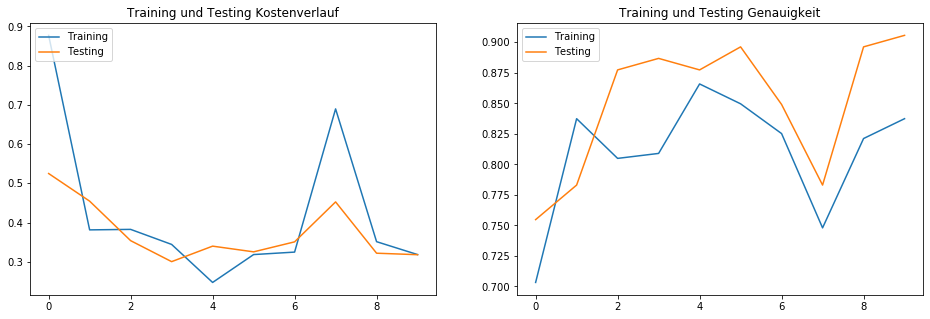

Genauigkeit: 87.74%
93 von 106 Beispielen richtig klassifiziert!


In [28]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=X_train,y=y_train,epochs=epochs, verbose=1, callbacks=[es], validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)

plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Testing')
ax1.legend(loc="upper left")
ax1.set_title("Training und Testing Kostenverlauf")
ax2.plot(history.history['acc'], label='Training')
ax2.plot(history.history['val_acc'], label='Testing')
ax2.legend(loc="upper left")#
ax2.set_title("Training und Testing Genauigkeit")
plt.show()

print("Genauigkeit: %.2f%%" % (scores[1]*100))
print(str(round(X_test.shape[0] * scores[1])) + " von " + str(X_test.shape[0]) + " Beispielen richtig klassifiziert!")